<a href="https://colab.research.google.com/github/sdsc-bw/DataFactory/blob/develop/demos/04_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning

To find a suitable model for your ML problem is very important. Not every model has the same performane on every task. Some models can be to simple (underfitting) and some models can be to complex for for a problem (overfitting). Also a model has different hyperparameters which also have an impact on the performance. Therefor exist libraries that can be used to find a appropriate model and its hyperparameters. In this github we use [hyperopt](https://github.com/hyperopt/hyperopt).

Not every model fits for every problem. In this notebook we can see the F1 scores of several models on different datasets. 

The F1 score is the harmonic mean of the precision and the recall: 
$$F1 = 2 * \frac{precision * recall}{precision + recall}$$
The higher the F1 score, the better the prediction. Precision and recall are defined as:

$$Precision = \frac{TP}{TP + FP}, Recall = \frac{TP}{TP + FN}$$
TP: True Positive, FN: False Negative, FP: False Positive

# How To use in the Datafactory

## Import packages

In [1]:
# if running in colab
import sys
if 'google.colab' in sys.modules:
    !git clone https://github.com/sdsc-bw/DataFactory.git # clone repository for colab
    !ls
    
    !pip install cloudpickle==1.6.0
    !pip install imgaug==0.2.6
    !pip install scipy==1.7.3 # install scipy to use hyperopt, RESTART RUNTIME AFTER THAT
    
    !pip install mlflow # install mlflow to use hyperopt
    
    # install auto-sklearn
    !sudo apt-get install build-essential swig
    !curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
    
    !pip install tsai # install tsai

In [2]:
import warnings # igorne irrelevant warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt # library used for visualization
import pandas as pd # library for creating tables
from hyperopt import hp # libary for finetuning and defining search spaces
from sklearn.datasets import load_wine # wine dataset

# add path to import datafactory 
import sys
if 'google.colab' in sys.modules:
    root = 'DataFactory/'
else:
    root = '../'
sys.path.append(root)

# Time series 
from datafactory.ts.preprocessing.cleaning import clean_data # method to clean data
from datafactory.ts.finetuning.finetuning import finetune # method to finetune with hyperopt
from datafactory.util.datasets import load_dataset

2022-02-07 17:47:33,337 - init


## Load dataset: Wine dataset

In [4]:
X, y = load_dataset('wine')

## How To Use the DataFactory

### Hyperopt

We provided a function to use hyperopt for finetuning. You can just create a list with models which you want to try out. We provide a standard search space for every model.

In [5]:
# list with models to try out
models = ['decision_tree', 'random_forest', 'ada_boost', 'inception_time', 'res_net', 'mini_rocket', 'res_cnn', 'lstm']

In [6]:
# loss in this case refers to -f1
# search strategy should be in ['parzen', 'random']
model = finetune(X, y, strategy='random', models=models, cv=3, max_evals=15, model_type='C')

,Model,Score,Hyperparams,Time
0,Random Forest,0.938230,"{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}",0.796869
1,Random Forest,0.938136,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.668213
2,ResNet,0.916667,"{'epochs': 150, 'lr_max': 0.001}",36.830833
3,ResNet,0.907407,"{'epochs': 150, 'lr_max': 0.001}",35.854107
4,AdaBoost,0.859322,"{'learning_rate': 0.1, 'n_estimators': 50}",0.266289
5,AdaBoost,0.848305,"{'learning_rate': 0.1, 'n_estimators': 100}",0.534570
6,AdaBoost,0.848305,"{'learning_rate': 0.1, 'n_estimators': 100}",0.457777
7,AdaBoost,0.848117,"{'learning_rate': 0.01, 'n_estimators': 200}",0.828784
8,Decision Tree,0.842938,"{'criterion': 'gini', 'max_depth': 4.0, 'min_samples_leaf': 2, 'min_samples_split': 3}",0.022936
9,MiniRocket,0.814815,"{'bn': True, 'epochs': 150, 'fc_dropout': 0.3, 'lr_max': 0.001, 'max_dilations_per_kernel': 16, 'num_features': 15000}",23.302677


100%|███████████████████████████████████████████████| 15/15 [03:41<00:00, 14.80s/trial, best loss: -0.9382297551789077]


Is you want to use your custom search space, then you have to define a *params* variable that defines the parameters to try out. If parameters for models are not given, it uses our standard search space.

If you want to define custom parameters, they should be defined with the functions of hyperopt. Look at the [sklearn](https://scikit-learn.org/stable/) and [tsai](https://github.com/timeseriesAI/tsai) website to find the hyperparamters of the models. Attention: The identifier of the hyperparameters need to be unique for ever parameter (also between models).

In [7]:
models = ['decision_tree', 'random_forest', 'ada_boost', 'inception_time', 'res_net']
# attention the label has to be unique for every parameter (also between models)
decision_tree_params = {'max_depth': hp.quniform('max_depth_dt', 1, 10, 1), 
                        'criterion': hp.choice('criterion_dt', ['gini', 'entropy']), 
                        'min_samples_leaf': hp.choice('min_samples_leaf_dt', [1, 2, 4])}
random_forest_params = {'max_depth': hp.choice('max_depth_rf', [1, 2, 3, 5, 10, 20, 50]), 
                        'n_estimators': hp.choice('n_estimators_rf', [50, 100, 200])}
ada_boost_params = {'n_estimators': hp.choice('n_estimators_ab', [50, 100, 200]), 
                    'learning_rate': hp.choice('learning_rate_ab', [0.001,0.01,.1,1.0])}
inception_time_params = {'epochs': hp.choice('epochs_it', [100, 150, 200]), 
                         'lr_max': 1e-3, 
                         'opt_func':  hp.choice('optimizer_it', ['adam', 'sgd']), 
                         'loss_func': hp.choice('loss_it', ['cross_entropy', 'smooth_cross_entropy']), 
                         'batch_tfms': hp.choice('batch_tfms_it', [['standardize', 'clip', 'mag_scale'], []]), 
                         'batch_size': [64, 128], 
                         'splits': None, 
                         'metrics': ['accuracy'],
                         'nf': hp.choice('nf_it', [32, 64]), 
                         'nb_filters': hp.choice('nb_filters_it', [32, 64, 96, 128])}
res_net_params = {'epochs': hp.choice('epochs__res_net', [100, 150, 200]), 
                  'lr_max': 1e-3, 
                  'opt_func':  hp.choice('optimizer__res_net', ['adam', 'sgd']), 
                  'loss_func': hp.choice('loss__res_net', ['cross_entropy', 'smooth_cross_entropy']), 
                  'batch_tfms': hp.choice('batch_tfms_res_net', [['standardize', 'clip', 'mag_scale'], []]), 
                  'batch_size': [64, 128], 
                  'splits': None, 
                  'metrics': ['accuracy']}
# put every hyperparameter definition in an own dictionary
params = {'decision_tree': decision_tree_params, 
          'random_forest': random_forest_params, 
          'ada_boost': ada_boost_params, 
          'inception_time': inception_time_params, 
          'res_net': res_net_params}

In [8]:
# search strategy should be in ['parzen', 'random']
model = finetune_hyperopt(X, y, strategy='random', models=models, cv=3, max_evals=15, model_type='C', params=params.copy())

,Model,Score,Hyperparams,Time
0,Random Forest,0.943785,"{'max_depth': 10, 'n_estimators': 200}",0.727055
1,Random Forest,0.943785,"{'max_depth': 3, 'n_estimators': 200}",0.732070
2,Random Forest,0.938324,"{'max_depth': 1, 'n_estimators': 200}",0.643280
3,Random Forest,0.932580,"{'max_depth': 20, 'n_estimators': 100}",0.423868
4,Decision Tree,0.898588,"{'criterion': 'gini', 'max_depth': 6.0, 'min_samples_leaf': 1}",0.023936
5,ResNet,0.898148,"{'batch_size': (64, 128), 'batch_tfms': ('standardize', 'clip', 'mag_scale'), 'epochs': 200, 'loss_func': 'smooth_cross_entropy', 'lr_max': 0.001, 'opt_func': 'sgd', 'splits': None}",50.325403
6,Decision Tree,0.882486,"{'criterion': 'entropy', 'max_depth': 6.0, 'min_samples_leaf': 4}",0.017952
7,Decision Tree,0.877024,"{'criterion': 'entropy', 'max_depth': 10.0, 'min_samples_leaf': 1}",0.021942
8,Decision Tree,0.859981,"{'criterion': 'entropy', 'max_depth': 7.0, 'min_samples_leaf': 2}",0.052858
9,AdaBoost,0.859322,"{'learning_rate': 0.1, 'n_estimators': 50}",0.281248


100%|███████████████████████████████████████████████| 15/15 [04:19<00:00, 17.27s/trial, best loss: -0.9437853107344633]


## Computer Vision

In [4]:
# Computer Vision
from datafactory.util.datasets import load_dataset, convert_dataset_to_numpy
from datafactory.cv.finetuning.finetuning import finetune
from datafactory.cv.plotting.plot_dataset import plot_images_as_grid
from datafactory.cv.preprocessing.loading import load_dataset_from_file

### Load Dataset: Cats vs Dogs

In [5]:
#dataset = load_dataset('mnist')
#X, y = convert_dataset_to_numpy(dataset, shuffle=False)
transform = ['resize']
transform_params = {'resize': {'size': (224, 224)}}
dataset = load_dataset_from_file(root + 'data/CatsVsDogs_demo/', transform=transform, transform_params=transform_params)
X, y = convert_dataset_to_numpy(dataset, shuffle=True)

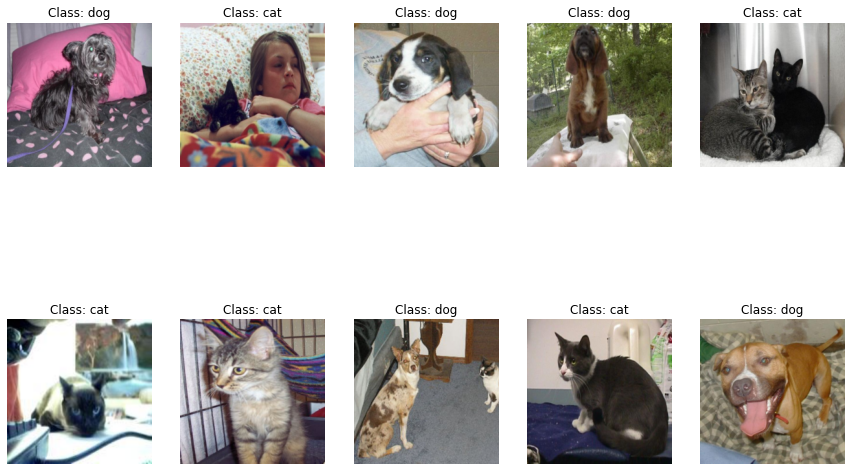

In [6]:
# visualize the dataset
plot_images_as_grid(X, y, idx={'0': 'cat', '1': 'dog'})

In [7]:
models = ['decision_tree', 'res_net', 'alex_net', 'efficient_net', 'reg_net', 'se_res_net', 'res_next']
model = finetune(dataset, strategy='random', models=models, cv=3, max_evals=15, model_type='C')

,Model,Score,Hyperparams,Time
0,ResNeXt,0.533333,"{'bottleneck_width': 2, 'cardinality': 16, 'epochs': 100, 'lr_max': 0.001, 'n_blocks': 26}",156.910726
1,AlexNet,0.466667,"{'epochs': 100, 'lr_max': 0.001, 'version': 'b'}",95.918108
2,Decision Tree,0.452381,"{'criterion': 'entropy', 'max_depth': 2.0, 'min_samples_leaf': 4, 'min_samples_split': 3}",0.614387
3,RegNet,0.400000,"{'epochs': 100, 'lr_max': 0.001, 'n_mf': 400, 'version': 'y'}",130.121745
4,ResNeXt,0.333333,"{'bottleneck_width': 4, 'cardinality': 32, 'epochs': 100, 'lr_max': 0.001, 'n_blocks': 26}",212.388736
5,EfficientNet,0.333333,"{'epochs': 100, 'lr_max': 0.001}",187.497921
6,EfficientNet,0.266667,"{'epochs': 100, 'lr_max': 0.001}",185.717089


2022-02-07 18:03:46,815 - Running cross validation for: EfficientNet...
2022-02-07 18:03:47,789 - job exception: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.86 GiB already allocated; 0 bytes free; 2.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 47%|█████████████████████▉                         | 7/15 [16:10<18:28, 138.62s/trial, best loss: -0.5333333333333333]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.86 GiB already allocated; 0 bytes free; 2.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF